# This notebook provides a slider to compare different physics parameters

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
import pandas as pd

import seaborn as sns
from scipy.interpolate import griddata

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Dropdown
import ipywidgets as widgets

from parameters_dict import physics_parameters, likelihood_levels_1d, detector_splitting_x, detector_splitting_z
from dark_nus_utils import load_datasets
from plot_utils import kde_variable_plot
from ctau_utils import ctau_heavy
from analyses_dict import analyses
from const import alphaQED
from likelihood_contours_plot import set_plot_style, set_canvas_basic, set_plot_title, plot_data_from_analysis
from parameters_dict import *
from exp_analysis_class import exp_analysis
from ctau_utils import ctau_heavy
from const import alphaQED
from Likelihood import LEff

In [3]:
hierarchy = 'heavy'
D_or_M = 'dirac'
save_folder = (f'../fig/4_analysis_variables_plots_single_simulated/')
!mkdir -p $save_folder
save_folder = (f'../fig/4_analysis_variables_plots_single_simulated/{hierarchy}_{D_or_M}_')

set_plot_style()

In [4]:
my_exp_analyses = {}
base_pars = (physics_parameters[hierarchy]['bp']['m4'], physics_parameters[hierarchy]['bp']['mz'])
for nu_mode, exp_code in zip(['FHC', 'RHC'], ['nd280_nu', 'nd280_nubar']):
    my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'] = exp_analysis(hierarchy, D_or_M, nu_mode, base_folder='../data')
    my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].load_df(*base_pars)

loading df 0.1, 1.25
initialising df 0.1, 1.25
loading df 0.1, 1.25
initialising df 0.1, 1.25


## Find the c$\tau$ we exclude at minimum

In [5]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['epsilon'] = 1e-20

base_like = 0
for nu_mode in ['FHC', 'RHC']:
    aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_FHC'].compute_likelihood_from_pars(
                                     my_exp_analyses[f'{hierarchy}_{D_or_M}_FHC'].dfs[base_pars],
                                     **this_point, 
                                     analysis=analyses['tpc']['FHC'], 
                                     like_normalized=False,
                                     is_scan=False)
    base_like += (-aux[0])

In [7]:
ctaus = np.geomspace(1e-1, 2, 51)
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['external_ctau'] = ctaus

leff = np.zeros(ctaus.shape)
mu_s = np.zeros(ctaus.shape)
sigma2_s = np.zeros(ctaus.shape)
for nu_mode in ['FHC', 'RHC']:
    aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                 my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].dfs[base_pars],
                                 **this_point, 
                                 analysis=analyses['tpc'][nu_mode], 
                                 like_normalized=False,
                                 is_scan=False)
    leff += aux[0]
    mu_s += aux[1]
    sigma2_s += aux[3]

leff *= -1
leff -= base_like

In [9]:
like_interp = interp1d(ctaus, leff-likelihood_levels_1d[0.9], kind='cubic')
r1 = root_scalar(like_interp, method='brentq', bracket=[1e-1, 2], 
                 fprime=None, fprime2=None, x0=0.2, x1=0.15)

In [10]:
r1.root

0.2963160933013877

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


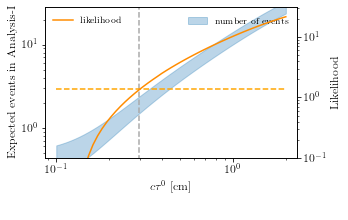

In [11]:
ax = set_canvas_basic()
ax.set_xlabel('$c\\tau^0$ [cm]')
ax.set_ylabel('Expected events in Analysis-I')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(mu_s[0], mu_s[-1])

ax.fill_between(ctaus, mu_s-np.sqrt(sigma2_s), mu_s+np.sqrt(sigma2_s), 
                color='C0', alpha=0.3, label='number of events')
ax.vlines(r1.root, 0, 1e4, color='darkgrey', ls='--')
ax.annotate('Excluded region', color='dodgerblue', xy=(1, 1e-1))
# ax.set_ylim(1e-2, 5e2)
# ax.set_ylim(1e1, 5e2)

ax2 = ax.twinx()
ax2.plot(ctaus, leff, color='darkorange', ls='-', label='likelihood')
ax2.set_yscale('log')
ax2.set_ylabel('Likelihood')
ax2.set_ylim(bottom=0.1)
ax2.hlines(likelihood_levels_1d[0.9], ctaus[0], ctaus[-1], ls='--', color='orange')

ax.legend()
ax2.legend()
# plt.savefig(save_folder+'n_events_vs_ctau.pdf', bbox_inches='tight')

## Paper plot

In [12]:
V_N_2_s = np.geomspace(physics_parameters['heavy']['bp']['Umu4_2'], 1e2, 25)
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['Ud4_2'] = V_N_2_s

ctaus = ctau_heavy(m4=this_point['m4'],
                   mz=this_point['mz'], 
                   Valpha4_alphaepsilon2=this_point['alpha_dark'] * this_point['Ud4_2'] * alphaQED * this_point['epsilon']**2, 
                   D_or_M=D_or_M)

leff = np.zeros(V_N_2_s.shape)
mu_s = np.zeros(V_N_2_s.shape)
sigma2_s = np.zeros(V_N_2_s.shape)
for nu_mode in ['FHC', 'RHC']:
    aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                 my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].dfs[base_pars],
                                 **this_point, 
                                 analysis=analyses['tpc'][nu_mode], 
                                 like_normalized=False,
                                 is_scan=False)
    leff += aux[0]
    mu_s += aux[1]
    sigma2_s += aux[3]

leff *= -1
leff -= base_like

In [13]:
like_interp = interp1d(ctaus, leff-likelihood_levels_1d[0.9], kind='cubic')
r1 = root_scalar(like_interp, method='brentq', bracket=[1e-2, 1], 
                 fprime=None, fprime2=None, x0=0.2, x1=0.15)
r2 = root_scalar(like_interp, method='brentq', bracket=[1e3, 1e5], 
                 fprime=None, fprime2=None, x0=1e4, x1=2e4)

In [14]:
print(r1.root, r2.root)

0.29694610046288644 4227.091613797332


(-1.0, 1.0)

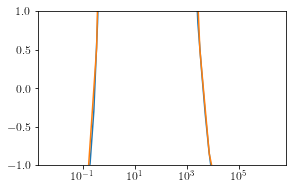

In [15]:
plt.plot(np.geomspace(1e-2, 1e5, 50), like_interp(np.geomspace(1e-2, 1e5, 50)))
plt.plot(ctaus, leff-likelihood_levels_1d[0.9])
plt.xscale('log')
# plt.yscale('log')
plt.ylim(-1, 1)

<ipython-input-16-2f8ab5999535>:18: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))
<ipython-input-16-2f8ab5999535>:18: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))


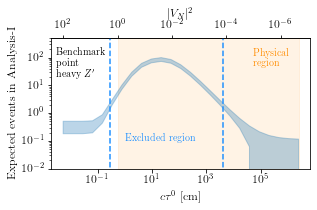

In [16]:
from scipy.interpolate import UnivariateSpline

fig = plt.figure()
axes_form = [0.17,0.19,0.81,0.64]
ax = fig.add_axes(axes_form)
ax.set_xlabel('$c\\tau^0$ [cm]')
ax.set_ylabel('Expected events in Analysis-I')
ax.set_xscale('log')
ax.set_yscale('log')

forward_fun = UnivariateSpline(np.log(ctaus[::-1]), np.log(V_N_2_s[::-1]), k=1)
backward_fun = UnivariateSpline(np.log(V_N_2_s), np.log(ctaus), k=1)

def forward(x):
    return np.exp(forward_fun(np.log(x)))

def backward(x):
    return np.exp(backward_fun(np.log(x)))

secax = ax.secondary_xaxis('top', functions=(forward, backward))
secax.set_xlabel('$|V_N|^2$')
secax.set_ticks

ax.fill_betweenx([1e-2, 1e4], 
                 backward(physics_parameters['heavy']['bp']['Umu4_2']), backward(1), 
                 color='darkorange', alpha=0.1)
ax.annotate('Physical\n region', color='darkorange', xy=(5e4, 5e1))

ax.fill_between(ctaus, mu_s-np.sqrt(sigma2_s), mu_s+np.sqrt(sigma2_s), 
                color='C0', alpha=0.3, label='number of events')
ax.vlines(r1.root, 0, 1e4, color='dodgerblue', ls='--')
ax.vlines(r2.root, 0, 1e4, color='dodgerblue', ls='--')
ax.annotate('Excluded region', color='dodgerblue', xy=(1, 1e-1))
ax.annotate('Benchmark\npoint\nheavy '+r'$Z^{\prime}$', color='black', xy=(3e-3, 20))
ax.set_ylim(1e-2, 5e2)

plt.savefig(save_folder+'n_events_vs_ctau_vs_V_ND.pdf')
plt.savefig(save_folder+'n_events_vs_ctau_vs_V_ND.png', bbox_inches='tight', transparent=True, dpi=500)

## Additional check

In [17]:
nu_mode = 'FHC'
aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                        my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].dfs[base_pars], 
                        m4=physics_parameters[hierarchy]['bp']['m4'], 
                        mz=physics_parameters[hierarchy]['bp']['mz'], 
                        alpha_dark=physics_parameters[hierarchy]['bp']['alpha_dark'], 
                        epsilon=physics_parameters[hierarchy]['bp']['epsilon'], 
                        Umu4_2=physics_parameters[hierarchy]['bp']['Umu4_2'], 
                        Ud4_2=None,
                        external_ctau=[r1.root],
                        ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                        pot=analyses['tpc'][nu_mode]['pot'],
                        selection_query=analyses['tpc'][nu_mode]['selection'],
                        efficiency_factor=analyses['tpc'][nu_mode]['efficiency'],
                        is_scan=False)

In [18]:
len(my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].dfs[base_pars])

661196

In [19]:
len(aux[0])

212889

In [20]:
aux[1].shape

(212889,)

In [21]:
aux[2]

array([[[[[[212889]]]]]])

In [22]:
aux[1][aux[0]['hydrogen']].sum()

0.07392335895800883

In [23]:
aux[1][aux[0]['carbon']].sum()

0.45230755208952883

In [24]:
aux[1][aux[0]['lead']].sum()

0.7170972424118744

In [25]:
aux[1][aux[0].eval('carbon & (int_point_z < 240)')].sum()

0.20450387734855943

In [26]:
aux[1][aux[0].eval('carbon & (int_point_z > 240)')].sum()

0.2478036747409694

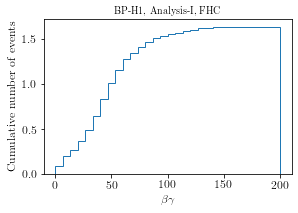

In [27]:
plt.hist(aux[0]['betagamma'], weights=aux[1], bins=30, range=(0,200), cumulative=True, histtype='step')
# plt.yscale('log')
plt.ylabel('Cumulative number of events')
plt.xlabel(r'$\beta \gamma$')
plt.title('BP-H1, Analysis-I, FHC')
plt.savefig(save_folder+'n_events_vs_betagamma_test.pdf', bbox_inches='tight')

# Geometrical acceptance

In [28]:
ctaus = np.geomspace(1e-2, 1e4, 20)

mu_s = {}
sigma2_s = {}

mu_s_noctau = {}
sigma2_s_noctau = {}

materials = ['lead', 'argon']
for selection in materials:
    mu_s[selection] = 0
    sigma2_s[selection] = 0
    mu_s_noctau[selection] = 0
    sigma2_s_noctau[selection] = 0
    for nu_mode in ['FHC', 'RHC']:
        aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                                    my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].dfs[base_pars], 
                                    m4=physics_parameters[hierarchy]['bp']['m4'], 
                                    mz=physics_parameters[hierarchy]['bp']['mz'], 
                                    alpha_dark=physics_parameters[hierarchy]['bp']['alpha_dark'], 
                                    epsilon=physics_parameters[hierarchy]['bp']['epsilon'], 
                                    Umu4_2=physics_parameters[hierarchy]['bp']['Umu4_2'], 
                                    Ud4_2=None,
                                    external_ctau=ctaus,
                                    ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                                    pot=analyses['tpc'][nu_mode]['pot'],
                                    selection_query=analyses['tpc'][nu_mode]['selection'] + " & " + selection,
                                    efficiency_factor=analyses['tpc'][nu_mode]['efficiency'],
                                    is_scan=False)
        mu_s[selection] += aux[1].sum(axis=0)
        sigma2_s[selection] += (aux[1]**2).sum(axis=0)
        
        aux_noctau = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                                    my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].dfs[base_pars], 
                                    m4=physics_parameters[hierarchy]['bp']['m4'], 
                                    mz=physics_parameters[hierarchy]['bp']['mz'], 
                                    alpha_dark=physics_parameters[hierarchy]['bp']['alpha_dark'], 
                                    epsilon=physics_parameters[hierarchy]['bp']['epsilon'], 
                                    Umu4_2=physics_parameters[hierarchy]['bp']['Umu4_2'], 
                                    Ud4_2=None,
                                    external_ctau=None,
                                    ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                                    pot=analyses['tpc'][nu_mode]['pot'],
                                    selection_query=analyses['tpc'][nu_mode]['selection'] + " & " + selection,
                                    efficiency_factor=analyses['tpc'][nu_mode]['efficiency'],
                                    is_scan=False)
        mu_s_noctau[selection] += aux_noctau[1].sum(axis=0)
        sigma2_s_noctau[selection] += (aux_noctau[1]**2).sum(axis=0)

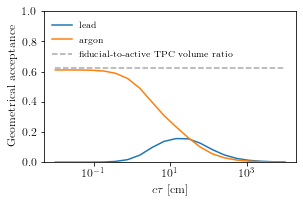

In [29]:
ax = set_canvas_basic()

for selection in materials:     
    ax.plot(ctaus, mu_s[selection]/mu_s_noctau[selection], label=selection)

ax.hlines(tpc_total_fiducial_volume/tpc_total_active_volume, ctaus[0], ctaus[-1], 
          ls='--', color='darkgrey',
          label='fiducial-to-active TPC volume ratio')

ax.set_xlabel('$c\\tau$ [cm]')
ax.set_ylabel('Geometrical acceptance')
ax.set_xscale('log')
ax.legend(frameon=False, loc='upper left')

ax.set_ylim(0, 1)

plt.savefig(save_folder+'geometrical_acceptance.pdf', bbox_inches='tight', transparent=True)
plt.savefig(save_folder+'geometrical_acceptance.png', bbox_inches='tight', dpi=500, transparent=True)

# 1d detector plot

In [30]:
ctaus = np.array([100, 1, 0.01])

aux = {}
aux_noctau = {}
for nu_mode in ['FHC', 'RHC']:
    aux[nu_mode] = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                                my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].dfs[base_pars], 
                                m4=physics_parameters[hierarchy]['bp']['m4'], 
                                mz=physics_parameters[hierarchy]['bp']['mz'], 
                                alpha_dark=physics_parameters[hierarchy]['bp']['alpha_dark'], 
                                epsilon=physics_parameters[hierarchy]['bp']['epsilon'], 
                                Umu4_2=physics_parameters[hierarchy]['bp']['Umu4_2'], 
                                Ud4_2=None,
                                external_ctau=ctaus,
                                ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                                pot=analyses['tpc'][nu_mode]['pot'],
                                selection_query=analyses['tpc'][nu_mode]['selection'],
                                efficiency_factor=analyses['tpc'][nu_mode]['efficiency'],
                                is_scan=False)
    aux_noctau[nu_mode] = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                                my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].dfs[base_pars], 
                                m4=physics_parameters[hierarchy]['bp']['m4'], 
                                mz=physics_parameters[hierarchy]['bp']['mz'], 
                                alpha_dark=physics_parameters[hierarchy]['bp']['alpha_dark'], 
                                epsilon=physics_parameters[hierarchy]['bp']['epsilon'], 
                                Umu4_2=physics_parameters[hierarchy]['bp']['Umu4_2'], 
                                Ud4_2=None,
                                external_ctau=None,
                                ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                                pot=analyses['tpc'][nu_mode]['pot'],
                                selection_query=analyses['tpc'][nu_mode]['selection'],
                                efficiency_factor=analyses['tpc'][nu_mode]['efficiency'],
                                is_scan=False)

In [31]:
out_noctau = []
out_noctau.append(pd.concat([aux_noctau['FHC'][0], aux_noctau['RHC'][0]]))
out_noctau.append(np.concatenate([aux_noctau['FHC'][1], aux_noctau['RHC'][1]], axis=0))

out = []
out.append(pd.concat([aux['FHC'][0], aux['RHC'][0]]))
out.append(np.concatenate([aux['FHC'][1], aux['RHC'][1]], axis=0))

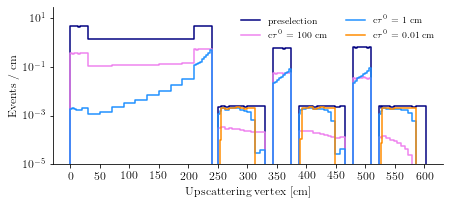

In [32]:
aux_binning = []
for i_split, splits in detector_splitting_z.items():
    if i_split in [3, 5, 7]:
        aux_binning += np.linspace(splits[0], tpc_fiducial_volume_endpoints[2][0] + (tpc_outer_volume[2] + fgd_outer_volume[2])*(i_split-3)/2, 3).tolist()
        aux_binning += np.linspace(tpc_fiducial_volume_endpoints[2][0] + (tpc_outer_volume[2] + fgd_outer_volume[2])*(i_split-3)/2, tpc_fiducial_volume_endpoints[2][1] + (tpc_outer_volume[2] + fgd_outer_volume[2])*(i_split-3)/2, 10).tolist()
        aux_binning += np.linspace(tpc_fiducial_volume_endpoints[2][1] + (tpc_outer_volume[2] + fgd_outer_volume[2])*(i_split-3)/2, splits[1], 3).tolist()
    else:
        aux_binning += np.linspace(*splits, 10).tolist()
binning_z = np.unique(np.array(aux_binning))
bin_widths = (binning_z[1:] - binning_z[:-1])
bin_centers = (binning_z[1:] + binning_z[:-1])/2

fig = plt.figure(figsize=(7,2.9))

hist, edges = np.histogram(out_noctau[0]['int_point_z'],
         bins=binning_z,
         weights=out_noctau[1])

plt.plot(np.concatenate([[0], edges]),
         np.concatenate([[0], hist/bin_widths, [0]]),
         color='navy',
         label='preselection',
         ds='steps-post')
colors = ['violet', 'dodgerblue', 'darkorange']
for i, ctau in enumerate(ctaus):
    hist, edges = np.histogram(out[0]['int_point_z'],
                                 bins=binning_z,
                                 weights=out[1][:, i])
    plt.plot(np.concatenate([[0], edges]),
         np.concatenate([[0], hist/bin_widths, [0]]),
         color=colors[i],
         label=f'c$\\tau^0$ = {ctau:.3g} cm',
         ds='steps-post')

plt.legend(frameon=False, ncol=2)
plt.yscale('log')
plt.ylim(1e-5, 30)
plt.ylabel(f'Events / cm')
plt.xlabel('Upscattering vertex [cm]')
plt.xticks(np.linspace(0, 600, 13));
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.savefig(save_folder+f'int_vertex_z.pdf', bbox_inches='tight')

# Detector plot

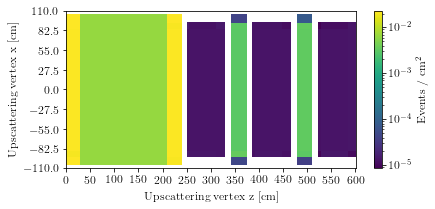

In [43]:
aux_binning = []
for i_split, splits in detector_splitting_z.items():
    if i_split in [3, 5, 7]:
        aux_binning += np.linspace(splits[0], tpc_fiducial_volume_endpoints[2][0] + (tpc_outer_volume[2] + fgd_outer_volume[2])*(i_split-3)/2, 2).tolist()
        aux_binning += np.linspace(tpc_fiducial_volume_endpoints[2][0] + (tpc_outer_volume[2] + fgd_outer_volume[2])*(i_split-3)/2, tpc_fiducial_volume_endpoints[2][1] + (tpc_outer_volume[2] + fgd_outer_volume[2])*(i_split-3)/2, 2).tolist()
        aux_binning += np.linspace(tpc_fiducial_volume_endpoints[2][1] + (tpc_outer_volume[2] + fgd_outer_volume[2])*(i_split-3)/2, splits[1], 2).tolist()
    else:
        aux_binning += np.linspace(*splits, 2).tolist()
binning_z = np.unique(np.array(aux_binning))
binning_x = [-p0d_dimensions[0]/2, -tpc_active_volume[0]/2, -tpc_fiducial_volume[0]/2, tpc_fiducial_volume[0]/2, tpc_active_volume[0]/2, p0d_dimensions[0]/2]

hist, edges_x, edges_y = np.histogram2d(out_noctau[0]['int_point_z'], out_noctau[0]['int_point_x'], 
               bins=(binning_z, binning_x), 
               weights=out_noctau[1])

mesh_x, mesh_y = np.meshgrid(edges_x, edges_y)

areas = np.outer((edges_x[1:] - edges_x[:-1]), (edges_y[1:] - edges_y[:-1]))

fig = plt.figure(figsize=(6.5,2.9))
plt.pcolormesh(edges_x, edges_y, (hist / areas).T, norm=LogNorm());
plt.xlabel('Upscattering vertex z [cm]')
plt.xticks(np.linspace(0, 600, 13))
plt.ylabel('Upscattering vertex x [cm]')
plt.yticks(np.linspace(-110, 110, 9))
plt.colorbar(label=r'Events / cm$^2$')
plt.savefig(save_folder + 'detector_vertex_2d.pdf', bbox_inches='tight')

# N events without ctau

In [49]:
aux_noctau = {}
for nu_mode in ['FHC', 'RHC']:
    aux_noctau[nu_mode] = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                                my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].dfs[base_pars], 
                                m4=physics_parameters[hierarchy]['bp']['m4'], 
                                mz=physics_parameters[hierarchy]['bp']['mz'], 
                                alpha_dark=physics_parameters[hierarchy]['bp']['alpha_dark'], 
                                epsilon=physics_parameters[hierarchy]['bp']['epsilon'], 
                                Umu4_2=physics_parameters[hierarchy]['bp']['Umu4_2'], 
                                Ud4_2=None,
                                external_ctau=None,
                                ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                                pot=analyses['tpc'][nu_mode]['pot'],
                                selection_query=None,
                                efficiency_factor=1,
                                is_scan=False)

In [50]:
out_noctau = []
out_noctau.append(pd.concat([aux_noctau['FHC'][0], aux_noctau['RHC'][0]]))
out_noctau.append(np.concatenate([aux_noctau['FHC'][1], aux_noctau['RHC'][1]], axis=0))

In [52]:
out_noctau[1].sum()

16231.976987071988